In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-7bf69874-ccd0-12f9-0886-20c8feaeb47c)


In [ ]:
!git clone https://github.com/forkbabu/segmentation_in_style.git repo
%cd repo
import gdown, os


Cloning into 'repo'...
remote: Enumerating objects: 205, done.
remote: Counting objects: 100% (205/205), done.
remote: Compressing objects: 100% (192/192), done.
remote: Total 205 (delta 86), reused 33 (delta 5), pack-reused 0
Receiving objects: 100% (205/205), 3.54 MiB | 7.91 MiB/s, done.
Resolving deltas: 100% (86/86), done.
/content/repo


In [ ]:
!wget -nc https://api.wandb.ai/files/ucalyptus/seginstyle/3hm84qqd/checkpoint/290000.pt
!pip install wandb
import wandb


--2021-12-19 08:11:52--  https://api.wandb.ai/files/ucalyptus/seginstyle/3hm84qqd/checkpoint/290000.pt
Resolving api.wandb.ai (api.wandb.ai)... 35.186.228.49
Connecting to api.wandb.ai (api.wandb.ai)|35.186.228.49|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: https://storage.googleapis.com/wandb-production.appspot.com/ucalyptus/Segmentation%20in%20Style/3hm84qqd/checkpoint/290000.pt?Expires=1639901572&GoogleAccessId=wandb-production%40appspot.gserviceaccount.com&Signature=VOp4iy9CpKBc6eO%2B8%2BcA1rq5Rfl4y1AvpIbSJAkzZOeBCGxMjQtaoMz6zRSYA2ynsUjuZP1vcJYPkcLZ%2FdHDYM2EZDdx7X2Q9sJWljgHcPqXv6oMH9HPGrSRg7j4uSCuD8ZKtfqoISzNxPW3bheiQfrRaviy9w2ojAHGeo1%2FtXT21H%2BYFGzFlbg%2BWADVtxH2GtdOALgCEnxJvEE4nfMz5IY6iQgRqFY8Ommzxv343urncruYKxe7gfbJHeWIhwFq6GH1MK0th7t7LeetjoWuNuaKZS6H4fntjIoFls22dq%2FdG9i0bbr%2BcAjJseb5Ex2rOGMJyo0UE3AVNZyVYCghnw%3D%3D [following]
--2021-12-19 08:11:52--  https://storage.googleapis.com/wandb-production.appspot.com/ucalyptus/Segme

In [ ]:
runn = wandb.init(project='seginstyle', entity='ucalyptus', name = 'k_multi');

wandb: Currently logged in as: ucalyptus (use `wandb login --relogin` to force relogin)


In [ ]:
import pickle
import torch


In [ ]:

wandb.config.epochs = 5

In [ ]:
import torch.nn as nn
import skimage
from skimage.color import rgb2hsv
import numpy as np

import argparse
import math
import os

import torch
from torch import optim
from tqdm import tqdm

from models.stylegan2.model import Generator
import skimage.io as io

def norm_ip(img, min, max):
    img = img.clamp(min=min, max=max)
    img = img.add(-min).div(max - min + 1e-5)
    return img


g_ema = Generator(1024, 512, 8)
output_path = "/content/repo/290000.pt"
g_ema.load_state_dict(torch.load(output_path)["g_ema"], strict=False)
"""with dnnlib.util.open_url(network_pkl) as f:
        G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore"""
g_ema.eval()
g_ema = g_ema.cuda()
mean_latent = g_ema.mean_latent(4096)

truncation = 0.5

features = None
imgs = None
with torch.no_grad():

  for i in range(wandb.config.epochs):
    sample_z = torch.randn(10, 512).cuda()
    style = g_ema.style(sample_z)
    style = mean_latent + truncation * (style - mean_latent)

    img_gen, _, out = g_ema([style], input_is_latent=True, randomize_noise=False, feature_layer_number_to_return=7)

    import skimage.io as io

    def norm_ip(img, min, max):
        img = img.clamp(min=min, max=max)
        img = img.add(-min).div(max - min + 1e-5)
        return img

    #two = norm_ip(img_gen_2[0:1, :, :, :].cpu().detach().squeeze().permute(1, 2, 0), min=-1.0, max=1.0).numpy()
    one_input = nn.functional.interpolate(img_gen,
                                      size=(128, 128),
                                      mode='bilinear',
                                      align_corners=True).clamp(min=-1.0, max=1.0).detach()
    out = nn.functional.interpolate(out,
                                 size=(128, 128),
                                 mode='bilinear',
                                 align_corners=True).detach()
    if imgs is None:
      imgs = one_input.cpu()
    else:
      aditional_imgs = one_input.cpu()
      imgs = torch.cat((imgs, aditional_imgs), axis=0)

    if features is None:
      features = out.cpu()
    else:
      additional_features = out.cpu()
      features = torch.cat((features, additional_features), axis=0)
features_new = features.permute(0, 2, 3, 1).reshape(-1, 512)


In [ ]:
import numpy as np
from skimage import io
from sklearn.cluster import KMeans
arr = features_new.detach().cpu().numpy()#dist.detach().cpu().numpy().reshape(-1, 1)

In [ ]:
import matplotlib.pyplot as plt

def plotter(k,n):
  plt.figure()
  #subplot(r,c) provide the no. of rows and columns
  f, axs = plt.subplots(n,1,figsize=(10,10))
  axs = axs.flatten()
  for i in range(0,n):
      axs[i].axis('off')
      axs[i].imshow(labels_spatial[k, :, :] == i,cmap ='viridis',alpha=0.8)
      axs[i].imshow(norm_ip(imgs[k, :, :, :].permute(1, 2, 0), min=-1.0, max=1.0).cpu().numpy(),alpha=0.6)
  wandb.log({str(k)+"_"+str(n): plt})
  


<Figure size 432x288 with 0 Axes>

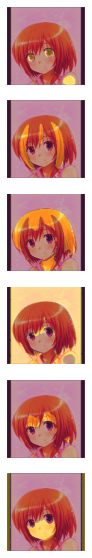

<Figure size 432x288 with 0 Axes>

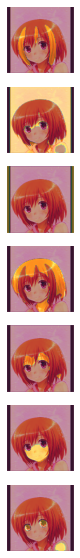

<Figure size 432x288 with 0 Axes>

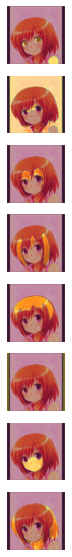

In [ ]:
for n in range(6,9):
  kmeans = KMeans(n_clusters=n, random_state=42).fit(arr)
  labels = kmeans.labels_
  centers = kmeans.cluster_centers_
  labels_spatial = labels.reshape(features.shape[0], features.shape[2], features.shape[3])
  integer_slider = 44 
  plotter(integer_slider,n)

In [ ]:
import PIL

In [ ]:
!touch foo.png

In [ ]:
def plotter_total(k):
  !rm foo.png
  plt.figure()
  f, axs = plt.subplots(1,2,figsize=(10,10))
  axs[0].axis('off')
  axs[1].axis('off')
  axs[1].imshow(labels_spatial[k, :, :],cmap ='viridis')
  extent = axs[1].get_window_extent().transformed(f.dpi_scale_trans.inverted())
  f.savefig('foo.png', bbox_inches=extent, dpi=52)
  axs[0].imshow(norm_ip(imgs[k, :, :, :].permute(1, 2, 0), min=-1.0, max=1.0).cpu().numpy())
  images = [wandb.Image(norm_ip(imgs[k, :, :, :].permute(1, 2, 0), min=-1.0, max=1.0).cpu().numpy(), caption="Image"),wandb.Image("foo.png", caption="Mask")]
  wandb.log({"image-mask_"+str(k): images})
  

rm: cannot remove 'foo.png': No such file or directory


<Figure size 432x288 with 0 Axes>

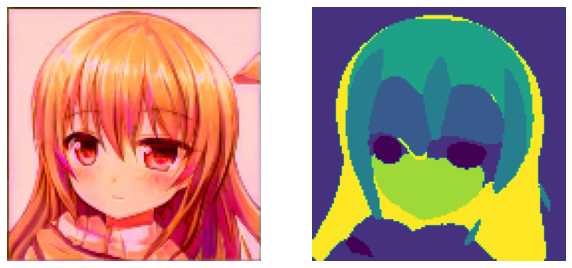

In [ ]:
#@title{ run: "auto" }
integer_slider = 24 #@param {type:"slider", min:0, max:49, step:1}
plotter_total(integer_slider)

In [ ]:
wandb.finish();